In [2]:
%pylab inline
import os
import pandas as pd
from PIL import Image, ImageFilter, ImageOps
from sklearn import decomposition, cluster
import cv2

Populating the interactive namespace from numpy and matplotlib


# 1) Get data

Gather our files paths

In [3]:
# Get local path
local_path = os.getcwd()

In [4]:
# List images folders
breeds_folders = [local_path + "/data/images/" + file_name for file_name in os.listdir(local_path + "/data/images") if os.path.isdir(local_path + "/data/images/" + file_name)]

In [5]:
# List breeds id and name
breeds_id = [breed_path.split("/")[-1].split("-")[0] for breed_path in breeds_folders]
breeds_name = [breed_path.split("/")[-1].split("-")[-1] for breed_path in breeds_folders]
breed_dict = dict(zip(breeds_id, breeds_name))

In [6]:
# List all images names
images = []
dog_id = []
breed_id = []
breed_name = []
full_path = []
for breed_folder in breeds_folders:
    # Get full pictures names
    files = [picture for picture in os.listdir(breed_folder) if picture.startswith("n")]
    images.extend(files)
    # Get pictures breed id
    breed_ids = [bids[0] for bids in list(map(lambda x: x.split("_"), files))]
    breed_id.extend(breed_ids)
    # Get dog id
    dog_ids = [did[0] for did in list(map(lambda x: x.split("_")[1].split("."), files))]
    dog_id.extend(dog_ids)
    # Convert breed id to breed name
    breed_names = [breed_dict[bid] for bid in breed_ids]
    breed_name.extend(breed_names)
    # Create full path to pictures
    full_paths = [breed_folder + "/" + file for file in files]
    full_path.extend(full_paths)

Now that we have our lists of data, gather into dataframe

In [7]:
data_mat = np.array([images, breed_id, breed_name, dog_id, full_path]).T

In [8]:
dogs_df = pd.DataFrame(data_mat, columns=['picture', 'breed_id', 'breed_name', 'breed_dog_id', 'pic_full_path'])

Have a look

In [9]:
dogs_df.sample(5)

,picture,breed_id,breed_name,breed_dog_id,pic_full_path
6928,n02095570_375.jpg,n02095570,Lakeland_terrier,375,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
16864,n02110185_11773.jpg,n02110185,Siberian_husky,11773,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
870,n02086240_5627.jpg,n02086240,Tzu,5627,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
3304,n02090622_5045.jpg,n02090622,borzoi,5045,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
12243,n02102973_26.jpg,n02102973,Irish_water_spaniel,26,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...


# 2) Playing with an example

First let's try to extract some features from a single picture

In [10]:
pic_sample = dogs_df.sample(1)
display(pic_sample)

,picture,breed_id,breed_name,breed_dog_id,pic_full_path
11092,n02100877_6747.jpg,n02100877,Irish_setter,6747,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...


#### Opening picture with PIL

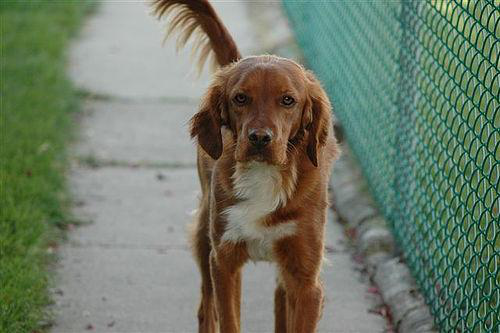

In [11]:
# Load the picture
img = Image.open(pic_sample.pic_full_path.values[0])
# display picture
img

In [12]:
# Get size of picture
sample_w, sample_h = img.size
print("Width : {} px, Height : {} px".format(sample_w, sample_h))

# Print picture's mode
print("Pixels format : {}".format(img.mode))

# Get picture's matrix
sample_mat = np.array(img)

# Display matrix size
print("Size of matrix : {}".format(sample_mat.shape))

Width : 500 px, Height : 333 px
Pixels format : RGB
Size of matrix : (333, 500, 3)


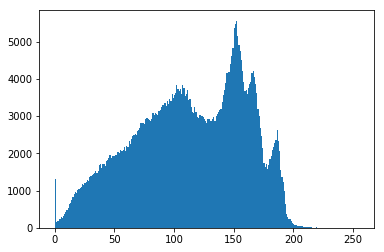

In [13]:
# Generate and display picture's histogram
# For normalized hist : density=True in plt.hist
# For cumulated histogram : cumulative=True
n, bins, patches = plt.hist(sample_mat.flatten(), bins=range(256))

One can notice the extremities pixels with higher values than their neighbors

#### Apply gaussian filter

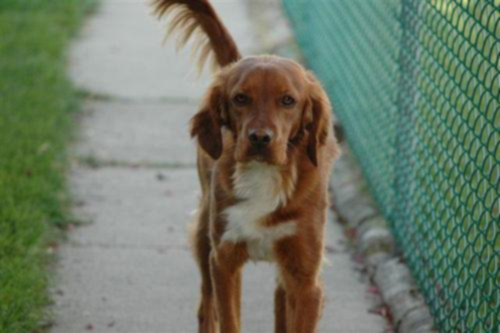

In [14]:
gaussian_img = img.filter(ImageFilter.GaussianBlur(radius=1))
gaussian_img

Gaussian blur as its name implies, blur our picture

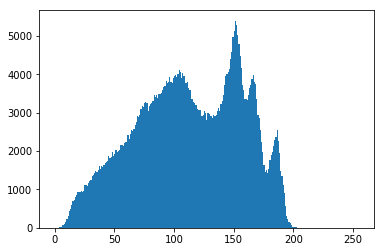

In [15]:
# Histogram of gaussian picture
gaussian_mat = np.array(gaussian_img)
n, bins, patches = plt.hist(gaussian_mat.flatten(), bins=range(256))

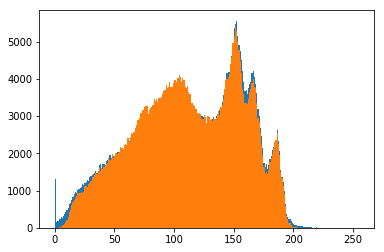

In [16]:
plt.hist(sample_mat.flatten(), bins=range(256));
plt.hist(gaussian_mat.flatten(), bins=range(256));

The gaussian filter reduced our high extremities pixels value to values closer to their neighbors

#### Apply histogram equalization

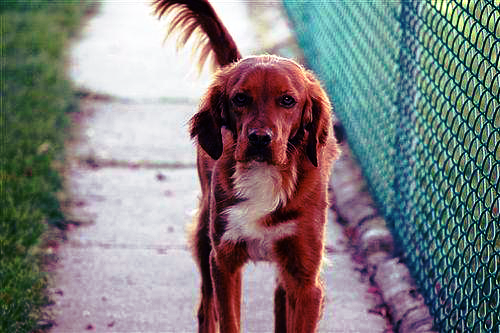

In [17]:
equalized_picture = ImageOps.equalize(img, mask=None)eeee
equalized_picture

Let's look at the histogram of this equalized picture

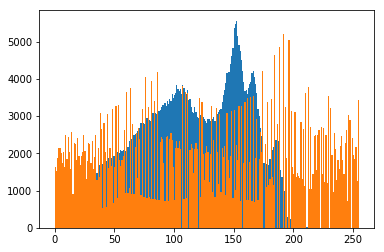

In [18]:
# Histogram of equalized picture
equalized_mat = np.array(equalized_picture)
plt.hist(sample_mat.flatten(), bins=range(256));
plt.hist(equalized_mat.flatten(), bins=range(256));

Equalization completely transformed our picture

#### Apply whitening

In [19]:
# Convert 3D to 2D for covariance computing
rgb_mat = np.hstack([sample_mat[:, :, 0], sample_mat[:, :, 1], sample_mat[:, :, 2]])

In [20]:
# Center matrix
X = rgb_mat - rgb_mat.mean(axis=0)

In [21]:
# compute the covariance of the image data
cov = np.cov(X, rowvar=True)   # cov is (N, N)
# singular value decomposition
U, S, V = np.linalg.svd(cov)     # U is (N, N), S is (N,)
# build the ZCA matrix
epsilon = 1e-5
pca_matrix = np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T)
zca_matrix = np.dot(U, pca_matrix)
# transform the image data       zca_matrix is (N,N)
pca = np.dot(pca_matrix, X)    
zca = np.dot(zca_matrix, X)    # zca is (N, 3072)

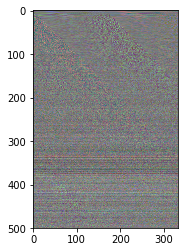

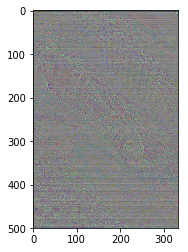

In [23]:
# Small helper function to display picture
def show(i):
    i = i.reshape((sample_w, 3, sample_h)).transpose(0, 2, 1)
    m, M = i.min(), i.max()
    plt.imshow((i - m) / (M - m))
    plt.show()

show(pca)
show(zca)

Let's look at the histogram of this whitened picture

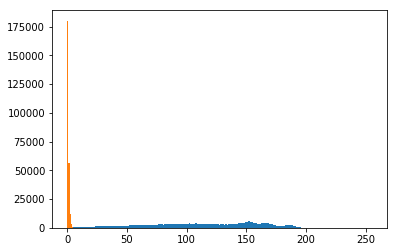

In [24]:
# Histogram of equalized picture
plt.hist(sample_mat.flatten(), bins=range(256));
plt.hist(zca.flatten(), bins=range(256));

Whitening completely transformed our picture, it shifted our histogram to the low values and increased pixels intensity.

#### Get SIFT features

Turn picture to greyscale

In [25]:
grey_pic = cv2.cvtColor(sample_mat, cv2.COLOR_BGR2GRAY)

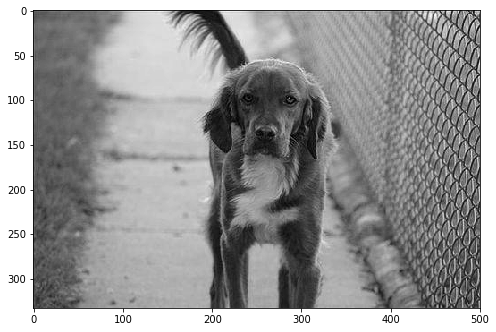

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(grey_pic, cmap='gray');

Generate SIFT features

Here are what our SIFT features look like for the sample image :


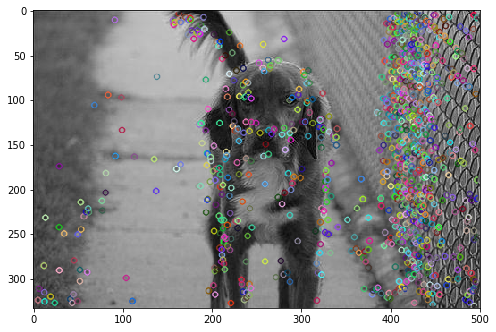

In [28]:
def gen_sift_features(grey_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(grey_img, None)
    return kp, desc

def show_sift_features(grey_img, color_img, kp):  
    fig, ax = plt.subplots(figsize=(8,8))
    return ax.imshow(cv2.drawKeypoints(grey_img, kp, color_img.copy()))

# generate SIFT keypoints and descriptors
image_kp, image_desc = gen_sift_features(grey_pic)

print('Here are what our SIFT features look like for the sample image :')
show_sift_features(grey_pic, sample_mat, image_kp);

In [29]:
print("%i keypoints have been found by the SIFT detector in the picture" % len(image_kp))

1086 keypoints have been found by the SIFT detector in the picture


In [30]:
def explain_keypoint(kp):
    print('angle\n', kp.angle)
    print('\nclass_id\n', kp.class_id)
    print('\noctave (image scale where feature is strongest)\n', kp.octave)
    print('\npt (x,y)\n', kp.pt)
    print('\nresponse\n', kp.response)
    print('\nsize\n', kp.size)

print('this is an example of a single SIFT keypoint:\n* * *')
explain_keypoint(image_kp[0])

this is an example of a single SIFT keypoint:
* * *
angle
 22.0126953125

class_id
 -1

octave (image scale where feature is strongest)
 9306368

pt (x,y)
 (5.111540794372559, 323.74371337890625)

response
 0.014118483290076256

size
 4.08575963973999


In [31]:
print('SIFT descriptors are vectors of shape', image_desc[0].shape)
print('they look like this:')
image_desc[0]

SIFT descriptors are vectors of shape (128,)
they look like this:


array([ 37.,  53.,  22.,  12.,   6.,   0.,   0.,   0.,  19.,  33.,  53.,
       130., 130.,   1.,   0.,   2.,  50.,  55.,  18.,  19.,  34.,  15.,
        16.,  27.,  14.,   6.,  10.,  17.,  31.,  58., 109.,  42.,   0.,
         5.,  18.,  15.,   9.,   4.,   0.,   0.,  11.,  33.,  92., 130.,
       115.,  64.,   3.,   3., 130., 130.,  61.,  31.,  13.,  12.,   6.,
        33., 122.,  46.,  42.,  13.,  17.,  14.,  62.,  59.,   0.,   0.,
         0.,   0.,   3.,   5.,   0.,   0.,   9.,   3.,   1.,  11., 102.,
       130.,  28.,  15., 130.,  53.,   5.,   4.,  20.,  77.,  49.,  88.,
        94.,  66.,  30.,   2.,   3.,   1.,   1.,   5.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,  17.,  19.,
         5.,   1.,   5.,   5.,   0.,   2.,   6.,  13.,  14.,   7.,   5.,
         4.,   0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

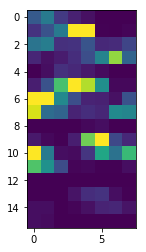

In [32]:
# Having a look at our descriptors
plt.imshow(image_desc[0].reshape(16,8), interpolation='none');

#### Gather our features in bag of visuals words through kmeans clustering

In [33]:
n_clust = int(np.floor(np.sqrt(len(image_desc))))

In [34]:
kmeans = cluster.KMeans(n_clusters=n_clust)
kmeans.fit(image_desc);

The clusters centers are our visual words

In [35]:
kmeans.cluster_centers_

array([[ 5.3809586, 25.285711 , 53.761894 , ..., 20.61905  , 66.99999  ,
        16.904762 ],
       [39.740746 , 15.481479 ,  8.759263 , ..., 21.648148 , 21.648148 ,
        28.685188 ],
       [24.956518 , 24.956522 , 10.521738 , ...,  3.7391272,  4.0434794,
        29.130436 ],
       ...,
       [45.95652  , 27.304348 , 29.78261  , ..., 16.78261  ,  6.9130445,
         9.956521 ],
       [15.263161 ,  7.2105236,  2.       , ..., 27.157894 ,  1.2105274,
         4.315789 ],
       [42.157894 , 23.578947 , 43.315792 , ..., 26.105263 , 11.052632 ,
        32.368416 ]], dtype=float32)

Classify our features locally

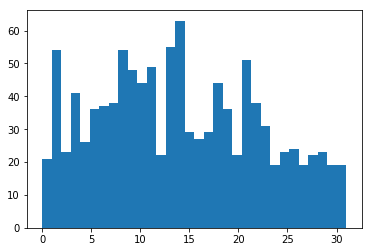

In [36]:
predict_kmeans = kmeans.predict(image_desc)
hist = plt.hist(predict_kmeans, bins=n_clust)

In [37]:
hist

(array([21., 54., 23., 41., 26., 36., 37., 38., 54., 48., 44., 49., 22.,
        55., 63., 29., 27., 29., 44., 36., 22., 51., 38., 31., 19., 23.,
        24., 19., 22., 23., 19., 19.]),
 array([ 0.     ,  0.96875,  1.9375 ,  2.90625,  3.875  ,  4.84375,
         5.8125 ,  6.78125,  7.75   ,  8.71875,  9.6875 , 10.65625,
        11.625  , 12.59375, 13.5625 , 14.53125, 15.5    , 16.46875,
        17.4375 , 18.40625, 19.375  , 20.34375, 21.3125 , 22.28125,
        23.25   , 24.21875, 25.1875 , 26.15625, 27.125  , 28.09375,
        29.0625 , 30.03125, 31.     ]),
 <a list of 32 Patch objects>)